In [1]:
# manual_orders = {
#     ('EQ', 0): (,0,),
#     ('EQ', 2): (,0,),
#     ('EQ', 4): (,0,),
#     ('EQ', 10): (,0,),
#     ('EQ', 13): (,0,),
#     ('EQ', 33): (,0,),
#     ('EQ', 56): (,0,),
#     ('Service', 0): (,0,),
#     ('Service', 2): (,0,),
#     ('Service', 4): (,0,),
#     ('Service', 10): (,0,),
#     ('Service', 13): (,0,),
#     ('Service', 33): (,0,),
#     ('Service', 56): (,0,),
#     ('Consumables', 0): (,0,),
#     ('Consumables', 2): (,0,),
#     ('Consumables', 4): (,0,),
#     ('Consumables', 10): (,0,),
#     ('Consumables', 13): (,0,),
#     ('Consumables', 33): (,0,),
# }


exog_features = [
    'MGDP_Index',
    'EBIT_Index',
    'Revenue_Index',
    'fleet1',
    'fleet2',
    'fleet3',
    'Copper',
    'Gold',
    'Iron Ore',
    'Nickel',
    'Silver',
    'Zinc',
]

In [2]:
import pandas as pd

import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller, pacf

get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings('ignore')


C:\Users\ilija\AppData\Local\Temp\ipykernel_25096\3365849852.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Service_0
MGDP_Index
EBIT_Index
Revenue_Index
fleet1
fleet2
fleet3
Copper
Gold
Iron Ore
Nickel
Silver
Zinc


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

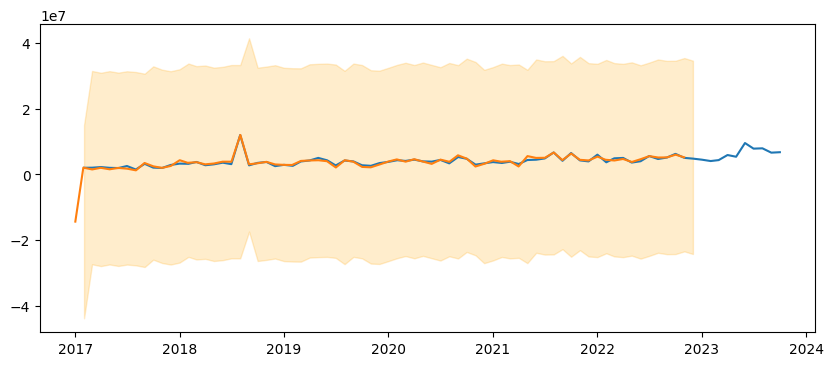

In [5]:
from utils import ts_data
from utils import ts_utils
importlib.reload(ts_data)
importlib.reload(ts_utils)

data_handler = ts_data.TsDataHandler(data_path = '../data')

bs_areas = data_handler.get_bussines_areas()
# bs_areas = ['EQ']
# bs_areas = ['Consumables']

regions = data_handler.get_regions()
# regions = [33]
# regions = [56]

all_models = True

forecasted_exogs_list = list()
forecasted_exogs = dict()

for bs_area in bs_areas:
    for region in regions: 
        if bs_area == 'Consumables' and region == 56:
            continue
        name = f'{bs_area}_{region}'
        print(name)

        sales_bus_region = data_handler.get_sales_per_business_area_and_region(business_area = bs_area,
                                                                               region = region)
        
        sales_bus_region = data_handler.add_monthly_financial_info(sales_df = sales_bus_region,
                                                                   region = region)

        ts_handler = ts_utils.TimeSeriesHandler(name = name,
                                                df = sales_bus_region,
                                                # endog = 'sales_value')
                                                endog = 'sales_value', exog = exog_features)
        
        if len(ts_handler.test) < 5:
            print('TEST NOT FULL ' + name)
            print(len(ts_handler.test))

        exog_forecast = pd.DataFrame()
        for exog in ts_handler.exog:
            
            exog_already_forecasted = False
            
            # check if current time series has already been forecasted
            for forecasted_exog in forecasted_exogs:
                if sales_bus_region[exog].values.tolist() in forecasted_exogs.keys():
                    exog_already_forecasted = True
                else:
                    forecasted_exogs.append(sales_bus_region[exog].values.tolist())

            if exog_already_forecasted:
                exog_forecast[exog] = forecasted_exogs[sales_bus_region[exog].values.tolist()]
                print(exog, ' already forecasted')
                continue
            else:
                print(exog)
                exog_name = f'{name}_exog_{exog}'
    
                exog_ts_handler = ts_utils.TimeSeriesHandler(name = exog_name,
                                                             df = sales_bus_region,
                                                             endog = exog,
                                                             exog = None,
                                                             endog_is_exog = True)
                if len(exog_ts_handler.test) < 5:
                    print('TEST NOT FULL '+ name + ' ' + exog_name)
                    print(len(exog_ts_handler.test))
    
                exog_ts_handler.determine_orders()
                # exog_ts_handler.fit_sarimax_exog(plot = False if all_models else True)
                exog_ts_handler.fit_sarimax(plot_fit = True,
                                            all_orders = True,
                                            plot_prediction = True,
                                            plot_rolling = True)
                exog_forecast[exog] = exog_ts_handler.forecast    
        
        ts_handler.set_exog_forecast(exog_forecast)

        # ts_handler.plot_acf_pacf()

        ts_handler.determine_orders()
        
        ts_handler.fit_sarimax(plot_fit = True,
                               all_orders = True,
                               plot_prediction = True,
                               plot_rolling = True)
        
        
        if not all_models: break
    if not all_models: break
